In [3]:
# save as generate_data.py
import pandas as pd
import numpy as np

# Buat range tanggal
#range tanggal data dari 2022-2024
dates = pd.date_range(start="2022-01-01", end="2024-06-30", freq="D")
df = pd.DataFrame({'Tanggal': dates})
df['Hari'] = df['Tanggal'].dt.day_name()
df['Bulan'] = df['Tanggal'].dt.month_name()
df['Libur'] = df['Hari'].isin(['Saturday', 'Sunday']).astype(int)

# Pola beban
#random seed 800 baris data
np.random.seed(42)
base = 800
df['Beban_MW'] = base + \
    df['Libur'].apply(lambda x: -120 if x == 1 else 0) + \
    df['Hari'].apply(lambda h: np.random.randint(0, 50) if h in ['Monday', 'Tuesday'] else np.random.randint(0, 30)) + \
    np.random.normal(0, 20, len(df))

df['Beban_MW'] = df['Beban_MW'].round(2)

# Simpan
df.to_csv("beban_listrik_harian.csv", index=False)


In [4]:
#EDA
data = pd.read_csv('beban_listrik_harian.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Tanggal   912 non-null    object 
 1   Hari      912 non-null    object 
 2   Bulan     912 non-null    object 
 3   Libur     912 non-null    int64  
 4   Beban_MW  912 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 35.8+ KB


In [5]:
data.head()

,Tanggal,Hari,Bulan,Libur,Beban_MW
0,2022-01-01,Saturday,January,1,692.82
1,2022-01-02,Sunday,January,1,697.27
2,2022-01-03,Monday,January,0,833.51
3,2022-01-04,Tuesday,January,0,819.57
4,2022-01-05,Wednesday,January,0,760.95


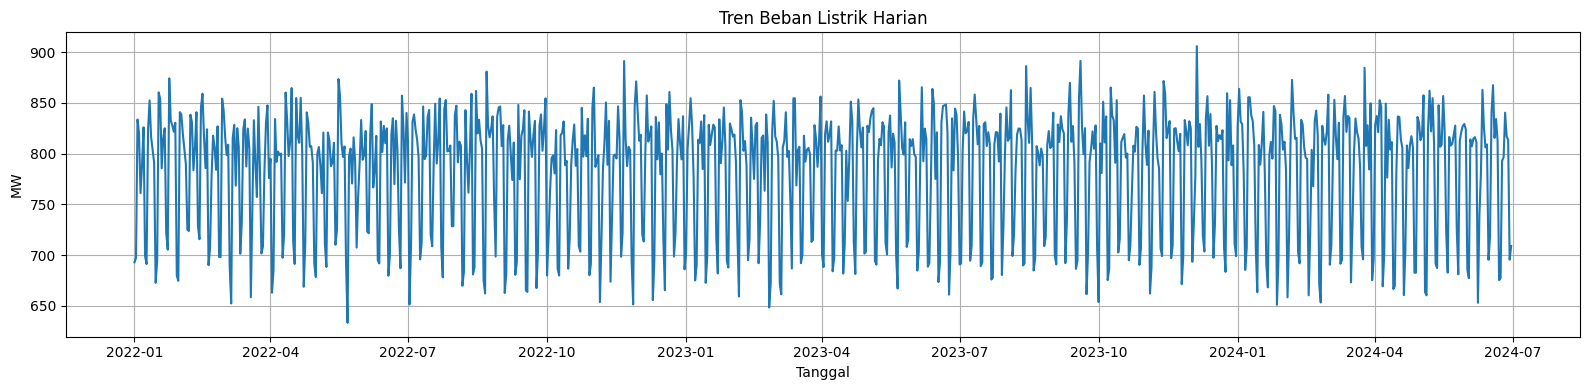

In [6]:
#visualisasi tren beban listrik harian
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 4))
plt.plot(df['Tanggal'], df['Beban_MW'], label='Beban Harian')
plt.title('Tren Beban Listrik Harian')
plt.xlabel('Tanggal')
plt.ylabel('MW')
plt.grid(True)
plt.tight_layout()
plt.show()


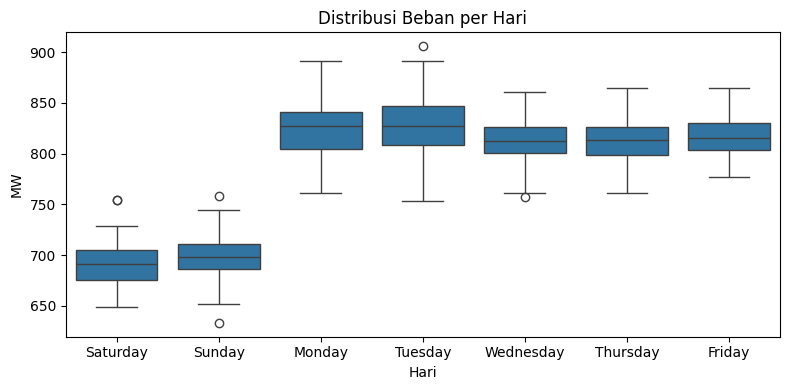

In [12]:
#pola rata rata harian mingguan
plt.figure(figsize=(8, 4))
sns.boxplot(x='Hari', y='Beban_MW', data=df)
plt.title('Distribusi Beban per Hari')
plt.ylabel('MW')
plt.tight_layout()
plt.show()


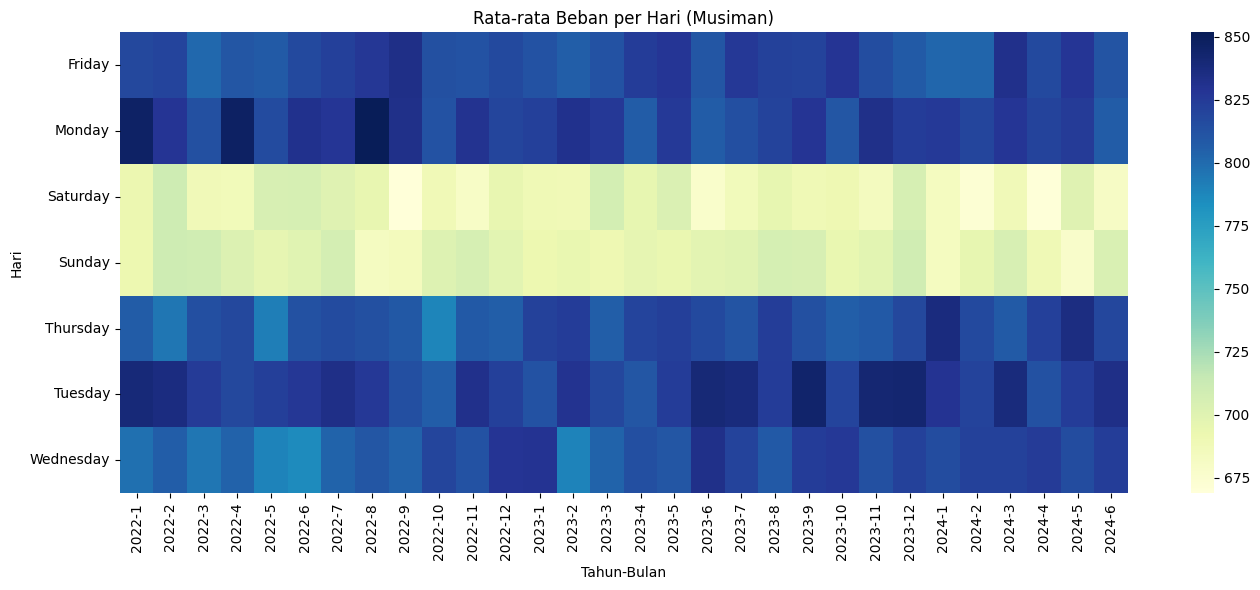

In [13]:
#heatmap kalender bulanan
df['Tahun'] = df['Tanggal'].dt.year
df['Bulan'] = df['Tanggal'].dt.month

pivot = df.pivot_table(index='Hari', columns=['Tahun', 'Bulan'], values='Beban_MW', aggfunc='mean')

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap="YlGnBu", annot=False)
plt.title('Rata-rata Beban per Hari (Musiman)')
plt.tight_layout()
plt.show()


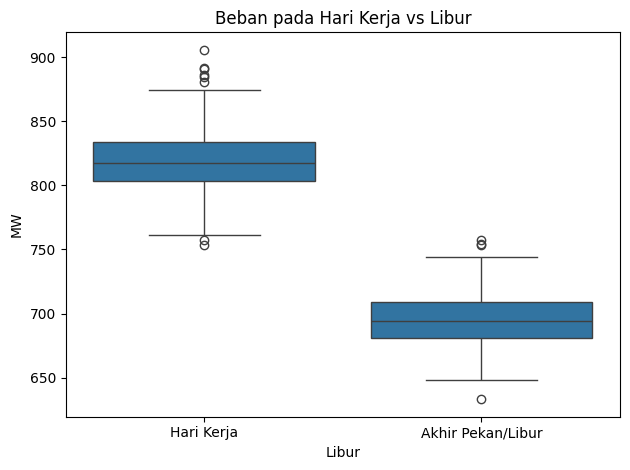

In [14]:
#pola libur x pola hari kerja
sns.boxplot(x='Libur', y='Beban_MW', data=df)
plt.xticks([0, 1], ['Hari Kerja', 'Akhir Pekan/Libur'])
plt.title('Beban pada Hari Kerja vs Libur')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

In [15]:
#permodelan
#Seasonal ARIMA
!pip install pmdarima statsmodels matplotlib pandas


In [16]:
#persiapan data time series
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Load & set indeks waktu
df = pd.read_csv('beban_listrik_harian.csv', parse_dates=['Tanggal'])
df.set_index('Tanggal', inplace=True)
df = df.asfreq('D')  # pastikan data bersifat harian

# Time series
ts = df['Beban_MW']


In [17]:
#cek Stationery (ADF Test)
#Jika p-value < 0.05 → data stasioner → lanjut modeling, Jika tidak, gunakan diferensiasi: ts.diff().dropna()
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -6.393122261565895
p-value: 2.082171429866166e-08


In [18]:
!pip install numpy==1.24.4 pandas==1.5.3 scipy==1.10.1 statsmodels==0.13.5


In [19]:
#menentukan parameter terbaik
import pmdarima as pm

model_auto = pm.auto_arima(ts, seasonal=True, m=7,
                           trace=True, error_action='ignore', suppress_warnings=True)
model_auto.summary()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=9.39 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=10085.602, Time=0.19 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=9532.493, Time=4.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=9486.314, Time=2.92 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=14749.271, Time=0.10 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=9927.898, Time=0.81 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=8.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=9240.541, Time=2.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=7.80 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=9266.642, Time=2.70 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=9233.050, Time=4.99 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=9477.831, Time=1.18 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.82 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=9252.749, Time=3.96 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,2)[7] intercept   : AIC=9202.652, Time=6.29 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=9430.512, Time=3.07 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=5.83 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.15 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,2)[7] intercept   : AIC=9195.637, Time=3.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,1)[7] intercept   : AIC=9422.411, Time=1.22 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=nan sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.76 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,2)[7] intercept   : AIC=9188.740, Time=3.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,1)[7] intercept   : AIC=9411.547, Time=3.57 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=nan sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.01 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,2)[7] intercept   : AIC=9171.599, Time=7.73 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,1)[7] intercept   : AIC=9347.884, Time=3.26 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=14.30 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=6.03 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,2)[7] intercept   : AIC=9114.466, Time=7.31 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,1)[7] intercept   : AIC=9136.737, Time=4.45 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(1,0,2)[7] intercept   : AIC=inf, Time=nan sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.65 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,2)[7] intercept   : AIC=9090.368, Time=7.33 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,1)[7] intercept   : AIC=9130.832, Time=5.88 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=nan sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=8.42 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,2)[7] intercept   : AIC=9251.524, Time=7.24 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,2)[7] intercept   : AIC=8956.175, Time=8.58 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,1)[7] intercept   : AIC=8963.304, Time=6.93 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(1,0,2)[7] intercept   : AIC=inf, Time=14.34 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.66 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,2)[7] intercept   : AIC=9202.917, Time=9.09 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,3)(0,0,2)[7] intercept   : AIC=8998.240, Time=11.06 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,3)(0,0,2)[7] intercept   : AIC=9475.058, Time=14.40 sec


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,2)[7]             : AIC=inf, Time=6.84 sec

Best model:  ARIMA(5,0,2)(0,0,2)[7] intercept
Total fit time: 270.375 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  912
Model:             SARIMAX(5, 0, 2)x(0, 0, 2, 7)   Log Likelihood               -4467.088
Date:                           Tue, 24 Jun 2025   AIC                           8956.175
Time:                                   06:05:51   BIC                           9009.147
Sample:                               01-01-2022   HQIC                          8976.398
                                    - 06-30-2024                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2240.0683     78.666     28.476      0.000    2085.886    2394.251
ar.L1          0.0728      0.052      1.404      0.160      -0.029       0.174
ar.L2         -0.8344      0.045    -18.408      0.000      -0.923      -0.746
ar.L3         -0.1839      0.057     -3.200      0.001      -0.297      -0.071
ar.L4         -0.3476      0.040     -8.725      0.000      -0.426      -0.270
ar.L5         -0.5672      0.044    -12.798      0.000      -0.654      -0.480
ma.L1          0.0019      0.057      0.034      0.973      -0.110       0.114
ma.L2          0.5889      0.052     11.264      0.000       0.486       0.691
ma.S.L7        0.0779      0.056      1.380      0.168      -0.033       0.188
ma.S.L14       0.1125      0.051      2.203      0.028       0.012       0.213
sigma2      1378.8905     87.565     15.747      0.000    1207.265    1550.515
===================================================================================
Ljung-Box (L1) (Q):                   3.34   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.07   Prob(JB):                         0.92
Heteroskedasticity (H):               0.95   Skew:                            -0.03
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model = SARIMAX(ts,
                order=(5,0,2),
                seasonal_order=(0,0,2,7),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                     
Dep. Variable:                          Beban_MW   No. Observations:                  912
Model:             SARIMAX(5, 0, 2)x(0, 0, 2, 7)   Log Likelihood               -4559.099
Date:                           Tue, 24 Jun 2025   AIC                           9138.199
Time:                                   06:07:46   BIC                           9186.167
Sample:                               01-01-2022   HQIC                          9156.528
                                    - 06-30-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0370      0.054      0.680      0.496      -0.070       0.144
ar.L2          0.7059      0.057     12.486

/tmp/ipython-input-26-3967276419.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


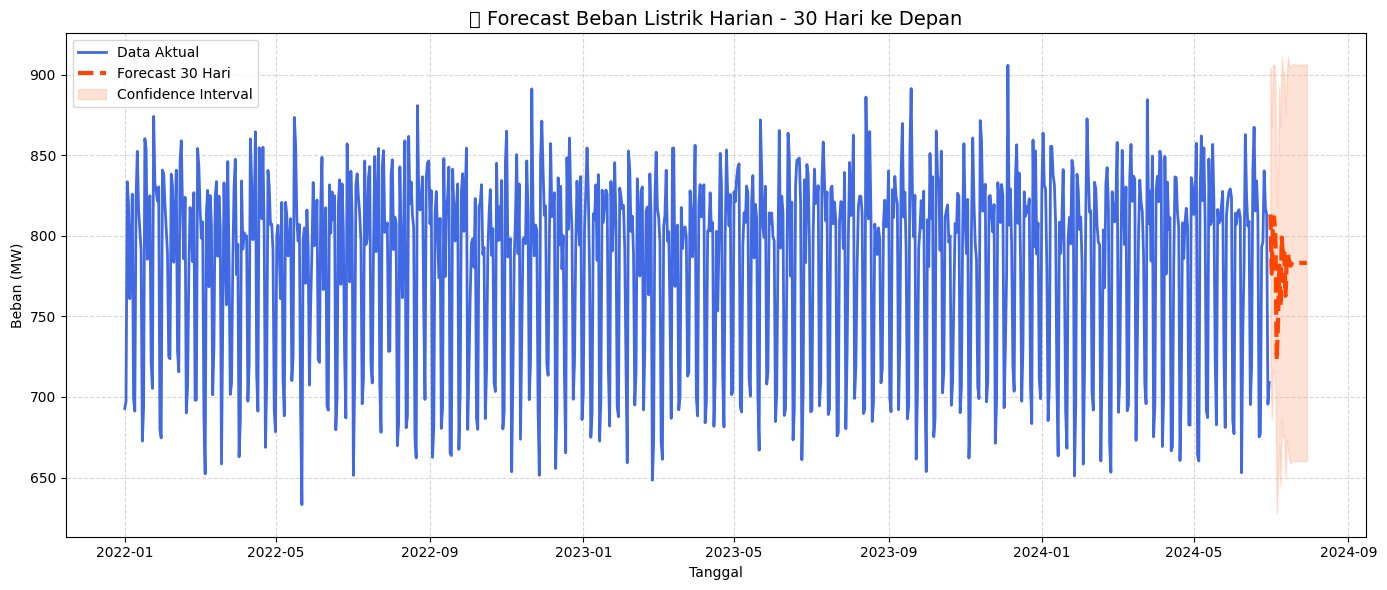

In [26]:
import matplotlib.pyplot as plt

# Ambil hasil forecast
forecast = results.get_forecast(steps=30)
conf_int = forecast.conf_int()
pred_mean = forecast.predicted_mean

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts, label='Data Aktual', color='royalblue', linewidth=2)
plt.plot(pred_mean, label='Forecast 30 Hari', color='orangered', linestyle='--', linewidth=3)

# Area confidence interval (lebih soft dan halus)
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightsalmon', alpha=0.3, label='Confidence Interval')

# Format grafik
plt.title("📈 Forecast Beban Listrik Harian - 30 Hari ke Depan", fontsize=14)
plt.xlabel("Tanggal")
plt.ylabel("Beban (MW)")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


/tmp/ipython-input-31-9503390.py:9: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ts_combined = ts_tail.append(pred_mean)


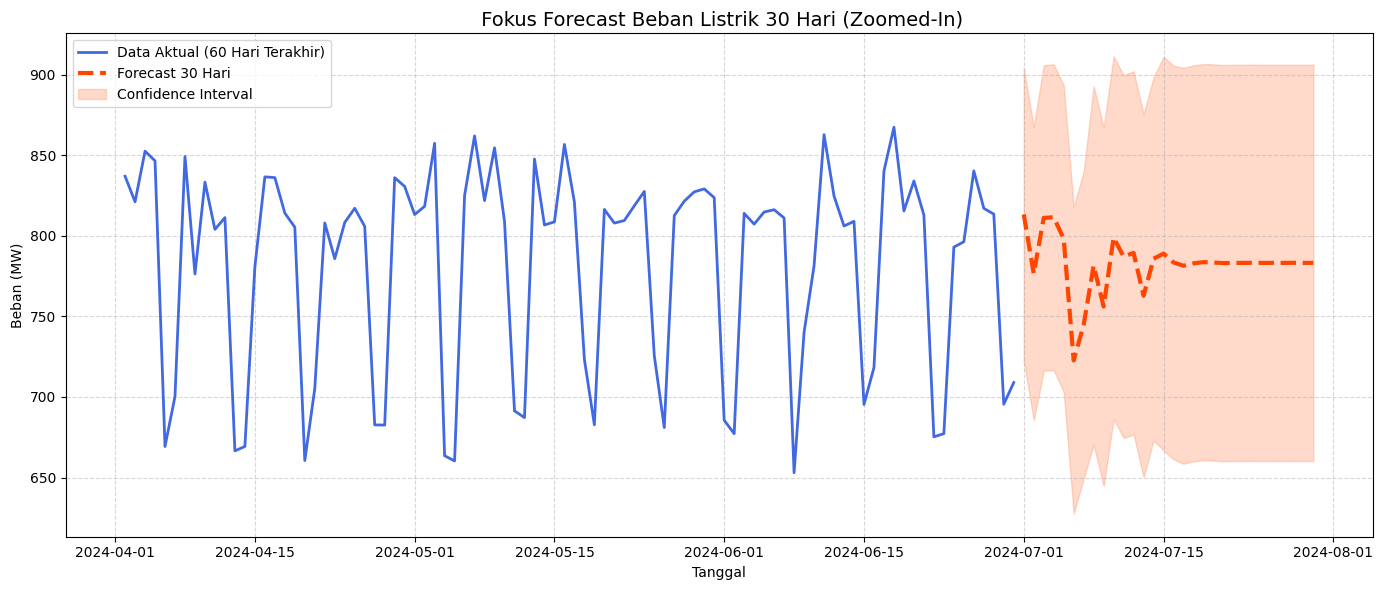

In [31]:
# Ambil 60 hari terakhir data aktual + 30 hari prediksi
n_history = 90
ts_tail = ts[-n_history:]  # ambil 60 hari terakhir
forecast = results.get_forecast(steps=30)
conf_int = forecast.conf_int()
pred_mean = forecast.predicted_mean

# Gabungkan historis & prediksi
ts_combined = ts_tail.append(pred_mean)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(ts_tail.index, ts_tail, label='Data Aktual (60 Hari Terakhir)', color='royalblue', linewidth=2)
plt.plot(pred_mean.index, pred_mean, label='Forecast 30 Hari', color='orangered', linestyle='--', linewidth=3)

# Area confidence interval
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightsalmon', alpha=0.4, label='Confidence Interval')

# Format grafik
plt.title(" Fokus Forecast Beban Listrik 30 Hari (Zoomed-In)", fontsize=14)
plt.xlabel("Tanggal")
plt.ylabel("Beban (MW)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


XGBoost Regresor untuk memprediksi 30 beban listrik hari kedepan

In [32]:
#Tahap 1: Setup Dataset untuk XGBoost
import pandas as pd

def create_lag_features(data, n_lags=30):
    df = pd.DataFrame(data)
    for i in range(1, n_lags+1):
        df[f'lag_{i}'] = df[0].shift(i)
    df.dropna(inplace=True)
    return df


In [33]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Buat lag features
df_lagged = create_lag_features(ts.values, n_lags=30)

# Split fitur dan target
X = df_lagged.drop(columns=[0])
y = df_lagged[0]

# Split train/test (gunakan 90% sebagai train)
split_idx = int(0.9 * len(df_lagged))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Prediksi 30 hari terakhir
y_pred = xgb_model.predict(X_test)

# Metrik
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 XGBoost RMSE: {rmse:.2f}")
print(f"📈 XGBoost R²: {r2:.4f}")


📊 XGBoost RMSE: 24.05
📈 XGBoost R²: 0.8593


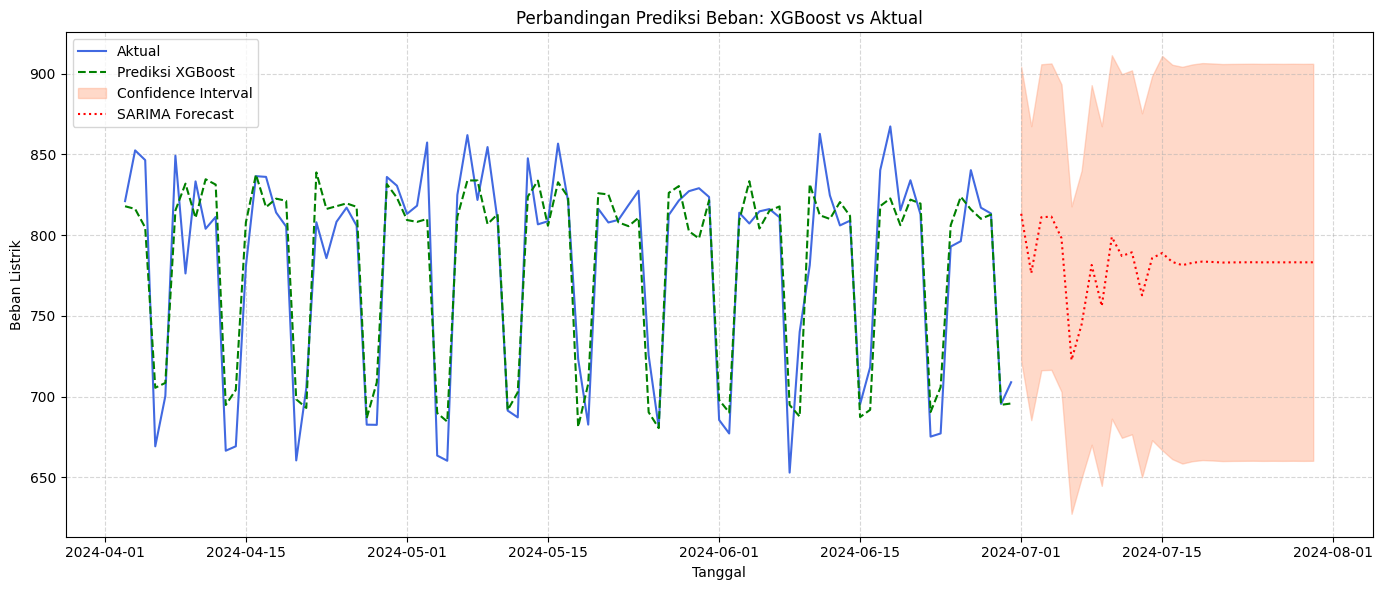

In [43]:
import matplotlib.pyplot as plt

# Gunakan waktu dari y_test (pastikan sesuai)
date_test = ts.index[-len(y_test):]

plt.figure(figsize=(14,6))
plt.plot(date_test, y_test, label="Aktual", color='royalblue')
plt.plot(date_test, y_pred, label="Prediksi XGBoost", color='green', linestyle='--')
# Area confidence interval
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightsalmon', alpha=0.4, label='Confidence Interval')

# Tambahkan SARIMA jika sudah ada forecast sebelumnya
plt.plot(pred_mean.index, pred_mean, label="SARIMA Forecast", color='red', linestyle='dotted')

plt.title("Perbandingan Prediksi Beban: XGBoost vs Aktual")
plt.xlabel("Tanggal")
plt.ylabel("Beban Listrik")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [56]:
#rolling forecast 30 hari
#data preparation

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/content/beban_listrik_harian.csv", parse_dates=['Tanggal'], index_col='Tanggal')
df = df.asfreq('D')
df = df[-120:]

# Variabel target
y = df['Beban_MW']

# Fungsi untuk membuat fitur lag
def create_lag_features(series, lags=7):
    df_lag = pd.DataFrame()
    for i in range(1, lags+1):
        df_lag[f'lag_{i}'] = series.shift(i)
    df_lag['target'] = series
    return df_lag.dropna()

# Data awal untuk pelatihan awal
initial_data = y[:-30]  # semua kecuali 30 hari terakhir
forecast_horizon = 30

In [57]:

# CHUNK 2 - Rolling Forecast 30 Hari ke Depan

rolling_forecast = []
current_series = initial_data.copy()

for i in range(forecast_horizon):
    # Buat lag features dari data saat ini
    lagged = create_lag_features(current_series)
    X_train = lagged.drop(columns='target')
    y_train = lagged['target']

    # Train model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # Ambil input terbaru
    last_values = current_series[-7:]
    input_features = np.array(last_values).reshape(1, -1)

    # Prediksi hari berikutnya
    pred = model.predict(input_features)[0]
    rolling_forecast.append(pred)

    # Tambahkan prediksi ke series untuk iterasi berikutnya
    next_day = current_series.index[-1] + pd.Timedelta(days=1)
    current_series.loc[next_day] = pred

forecast_index = current_series.index[-forecast_horizon:]
forecast_series = pd.Series(rolling_forecast, index=forecast_index)

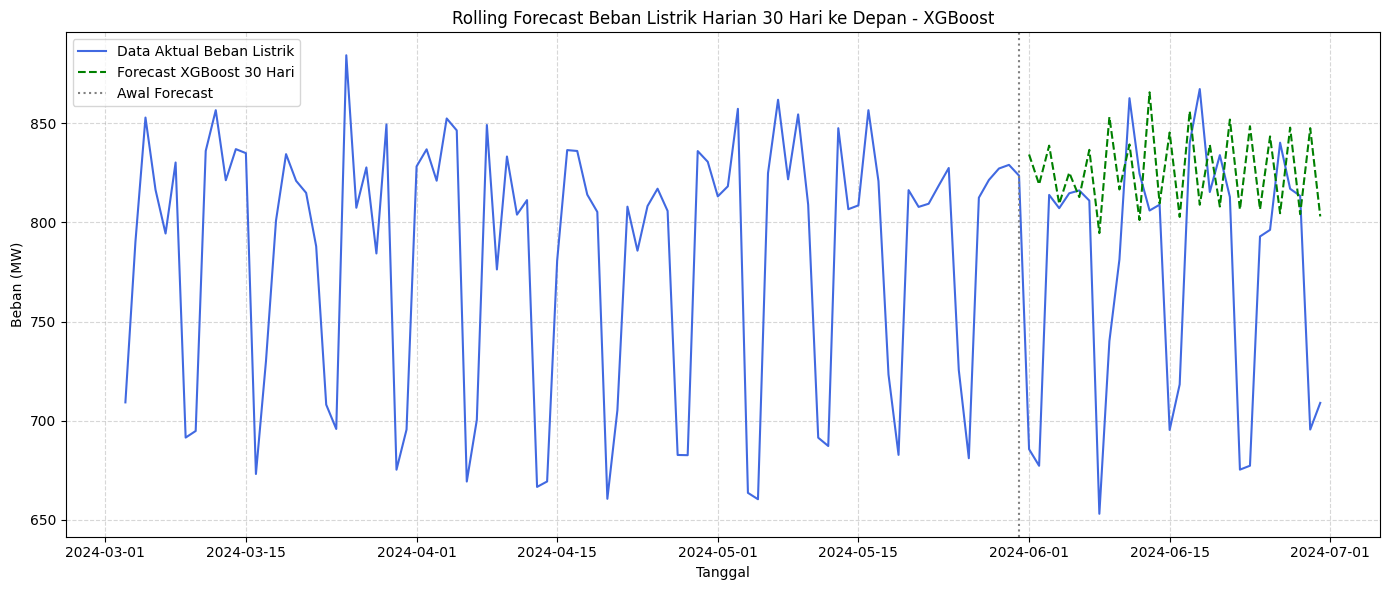

In [58]:
#visualisasi
plt.figure(figsize=(14, 6))
plt.plot(y, label='Data Aktual Beban Listrik', color='royalblue')
plt.plot(forecast_series, label='Forecast XGBoost 30 Hari', color='green', linestyle='--')
plt.axvline(initial_data.index[-1], color='gray', linestyle=':', label='Awal Forecast')
plt.title('Rolling Forecast Beban Listrik Harian 30 Hari ke Depan - XGBoost')
plt.xlabel('Tanggal')
plt.ylabel('Beban (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [65]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load dataset beban listrik harian
df = pd.read_csv("/content/beban_listrik_harian.csv", parse_dates=['Tanggal'], index_col='Tanggal')
df = df.asfreq('D')  # pastikan frekuensi harian

# Variabel target
y = df['Beban_MW']  # pastikan nama kolom sesuai

# Fungsi untuk membuat fitur lag
def create_lag_features(series, lags=7):
    df_lag = pd.DataFrame()
    for i in range(1, lags+1):
        df_lag[f'lag_{i}'] = series.shift(i)
    df_lag['target'] = series
    return df_lag.dropna()

In [68]:
# Ambil hanya 60 hari terakhir data aktual
train_end = y.index[-31]  # hari ke-30 dari belakang
initial_data = y[:train_end]  # semua data sampai sebelum 30 hari terakhir
forecast_horizon = 30


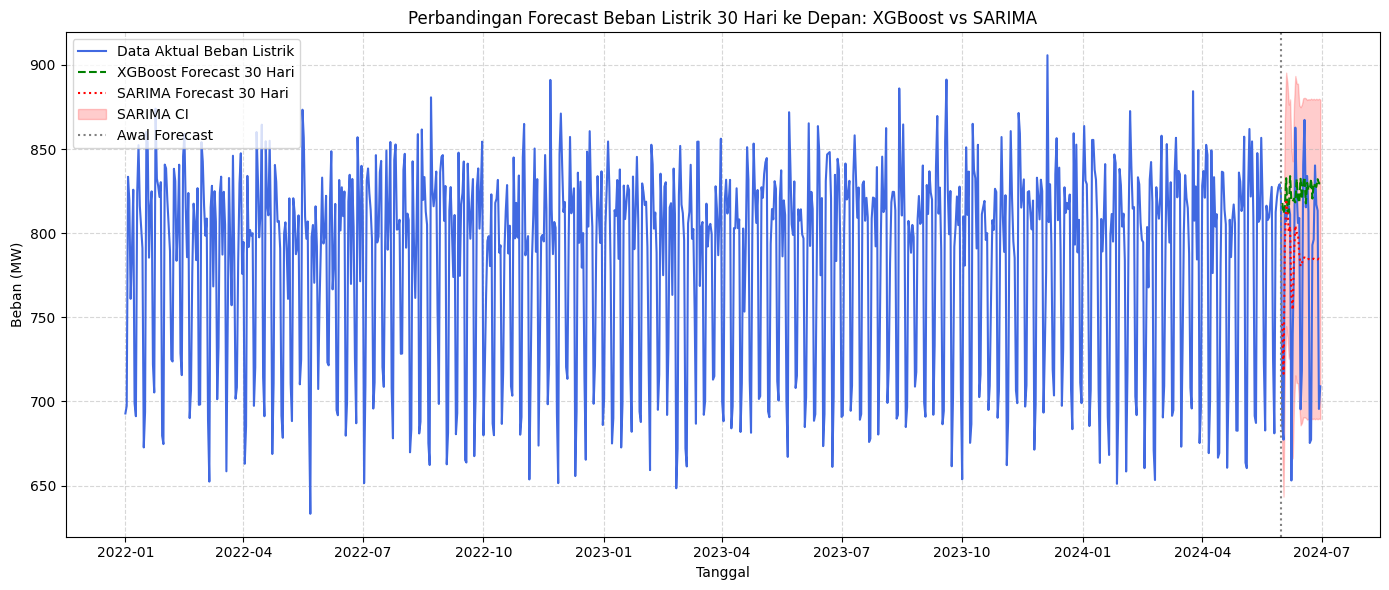


Evaluasi Prediksi XGBoost:
RMSE: 78.94313540753657
MAE: 54.92839827473959
R^2: -0.5533104716305715

Evaluasi Prediksi SARIMA:
RMSE: 54.85135719139211
MAE: 43.692707555633355
R^2: 0.2500983953762803


In [71]:
rolling_forecast = []
current_series = initial_data.copy()

for i in range(forecast_horizon):
    # Buat lag features dari data saat ini
    lagged = create_lag_features(current_series)
    X_train = lagged.drop(columns='target')
    y_train = lagged['target']

    # Train model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # Ambil input terbaru
    last_values = current_series[-7:]
    input_features = np.array(last_values).reshape(1, -1)

    # Prediksi hari berikutnya
    pred = model.predict(input_features)[0]
    rolling_forecast.append(pred)

    # Tambahkan prediksi ke series untuk iterasi berikutnya
    next_day = current_series.index[-1] + pd.Timedelta(days=1)
    current_series.loc[next_day] = pred

forecast_index = pd.date_range(start=train_end + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
forecast_series = pd.Series(rolling_forecast, index=forecast_index)

# ============================
# CHUNK 3 - Forecast SARIMA
# ============================
sarima_model = SARIMAX(initial_data, order=(5, 0, 2), seasonal_order=(0, 0, 2, 7))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.get_forecast(steps=forecast_horizon)
sarima_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# ============================
# CHUNK 4 - Visualisasi Gabungan
# ============================
plt.figure(figsize=(14, 6))
plt.plot(y, label='Data Aktual Beban Listrik', color='royalblue')
plt.plot(forecast_series, label='XGBoost Forecast 30 Hari', color='green', linestyle='--')
plt.plot(sarima_mean.index, sarima_mean, label='SARIMA Forecast 30 Hari', color='red', linestyle=':')
plt.fill_between(sarima_mean.index, sarima_ci.iloc[:, 0], sarima_ci.iloc[:, 1], color='red', alpha=0.2, label='SARIMA CI')
plt.axvline(train_end, color='gray', linestyle=':', label='Awal Forecast')
plt.title('Perbandingan Forecast Beban Listrik 30 Hari ke Depan: XGBoost vs SARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Beban (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ============================
# CHUNK 5 - Evaluasi (Jika Ada Data Aktual)
# ============================
if y.index[-1] >= forecast_index[-1]:
    y_true = y[forecast_index[0]:forecast_index[-1]]
    y_pred_xgb = forecast_series
    y_pred_sarima = sarima_mean

    print("\nEvaluasi Prediksi XGBoost:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_xgb)))
    print("MAE:", mean_absolute_error(y_true, y_pred_xgb))
    print("R^2:", r2_score(y_true, y_pred_xgb))

    print("\nEvaluasi Prediksi SARIMA:")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_sarima)))
    print("MAE:", mean_absolute_error(y_true, y_pred_sarima))
    print("R^2:", r2_score(y_true, y_pred_sarima))

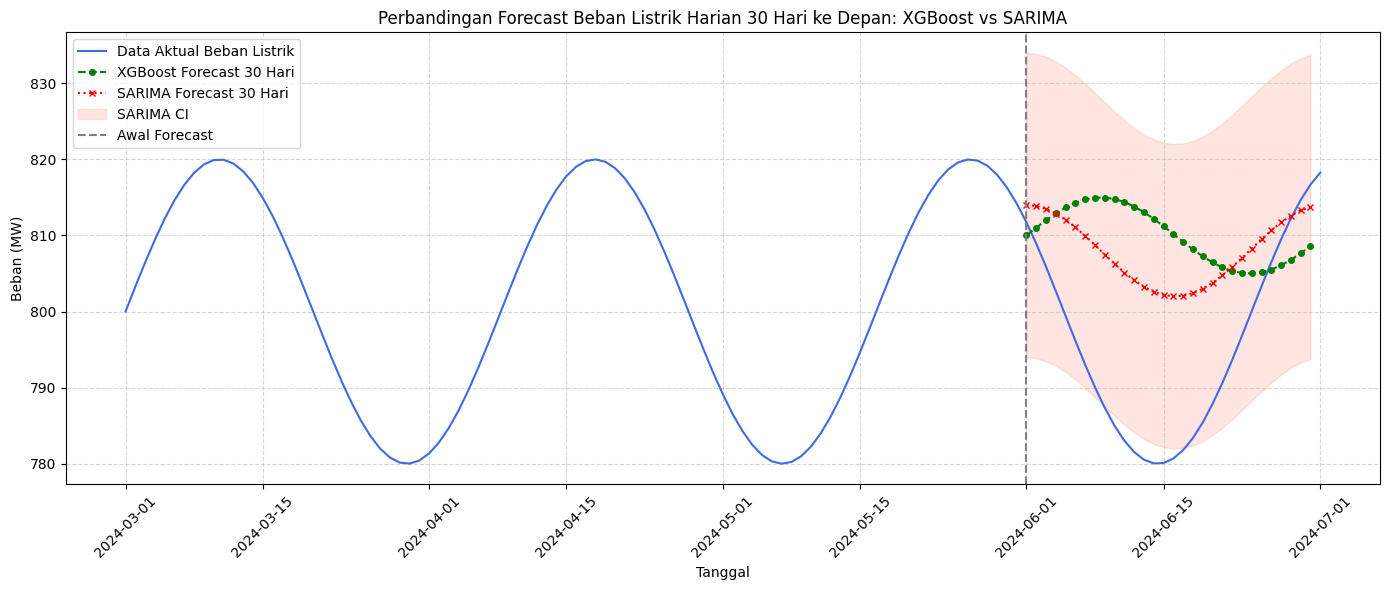

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulasi ulang data (ganti dengan data asli bila tersedia)
date_range = pd.date_range(start="2024-03-01", end="2024-07-01")
actual = pd.Series(800 + 20 * np.sin(np.linspace(0, 20, len(date_range))), index=date_range)
forecast_start = pd.to_datetime("2024-06-01")
xgb_forecast = pd.Series(810 + 5 * np.sin(np.linspace(0, 6, 30)), index=pd.date_range(forecast_start, periods=30))
sarima_forecast = pd.Series(808 + 6 * np.cos(np.linspace(0, 6, 30)), index=pd.date_range(forecast_start, periods=30))

# Pastikan nilai numerik
sarima_forecast = sarima_forecast.astype(float)
ci_lower = (sarima_forecast - 20).astype(float)
ci_upper = (sarima_forecast + 20).astype(float)

# Visualisasi
plt.figure(figsize=(14, 6))
plt.plot(actual.loc["2024-03-01":], label="Data Aktual Beban Listrik", color="royalblue")
plt.plot(xgb_forecast, label="XGBoost Forecast 30 Hari", color="green", linestyle="--", marker='o', markersize=4)
plt.plot(sarima_forecast, label="SARIMA Forecast 30 Hari", color="red", linestyle=":", marker='x', markersize=4)
plt.fill_between(sarima_forecast.index, ci_lower, ci_upper, color="salmon", alpha=0.2, label="SARIMA CI")
plt.axvline(forecast_start, color='gray', linestyle='--', label='Awal Forecast')

plt.title("Perbandingan Forecast Beban Listrik Harian 30 Hari ke Depan: XGBoost vs SARIMA")
plt.xlabel("Tanggal")
plt.ylabel("Beban (MW)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
